# Modules

In [119]:
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
from math import pi,cos,radians
import pyproj
from shapely.ops import cascaded_union
from shapely.geometry import Point
import shapely.geometry as shpg
import salem
import datetime as dt
%matplotlib inline

# Paths

In [2]:
lp_p = 'C:\\Users\\jlandman\\Desktop\\LeBris_Paul\\ElevationChange_GlaciersSupp1km2_LessThan20%DataVoid.shp' # LeBris/Paul shape
foga_p = 'C:\\Users\\jlandman\\Desktop\\DOI-WGMS-FoG-2015-11\\WGMS-FoG-2015-11-A-GENERAL-INFORMATION.csv'
rgi_ak_p = 'C:\\Users\\jlandman\\Desktop\\01_rgi50_Alaska\\01_rgi50_Alaska_selecxt_LeBris_2km.shp'

# Read files

In [3]:
lp = gpd.read_file(lp_p)
rgi_ak = gpd.read_file(rgi_ak_p)
lp['ID'] = lp['ID'].astype(int)
foga = pd.read_csv(foga_p, encoding='iso-8859-1')

# Make an empty FoG-D DataFrame

In [4]:
fogd_templ = pd.DataFrame([], [['POLITICAL_UNIT', 'GLACIER_NAME', 'WGMS_ID', 'YEAR', 'LOWER_BOUND', 'UPPER_BOUND', 
                                'AREA_SURVEY_YEAR', 'AREA_CHANGE', 'AREA_CHANGE_UNCERTAINTY', 'THICKNESS_CHANGE', 
                                'THICKNESS_CHANGE_UNCERTAINTY', 'VOLUME_CHANGE', 'VOLUME_CHANGE_UNCERTAINTY', 'SURVEY_DATE',
                                'SURVEY_DATE_PLATFORM_METHOD', 'REFERENCE_DATE', 'REFERENCE_DATE_PLATFORM_METHOD',
                                'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE', 'REMARKS']])

# Determine uncertainty for given FoG coordinate

In [5]:
def coord_unc(x,y):
    """ Determine the uncertainity in meters for a given FoG coordinate at its lat/lon (assuming earth was a sphere)
    
    Parameters
    -----------
    x: longitude in degrees
    y: latitude in degrees
    
    Returns
    --------
    dx, dy: uncertainty in meters
    """
    # assert given numbers are floats
    # and determine number of decimals given
    if isinstance(x, int):
        xd = 0
    elif isinstance(x, float):
        xd = str(x)[::-1].find('.')
    else:
        raise TypeError('Given x must be float or integer.)')
        
    if isinstance(y, int):
        yd = 0
    elif isinstance(y, float):
        yd = str(y)[::-1].find('.')
    else:
        raise TypeError('Given y must be float or integer.)')
    
    # maximum error in degrees
    xe = 10**(-xd)
    ye = 10**(-yd)
    
    # maximum error in meters
    dy = ye * ((2.* pi * 6378000.) / 360.)
    dx = xe * (2. * pi * cos(radians(y)) * 6378000.) / 360.
    
    print(dx, dy)
    return dx, dy

In [6]:
def transform_coords(x,y,in_proj=None,out_proj=None):
    
    assert in_proj is not None,'Input projection may not be None.'
    assert out_proj is not None,'Output projection may not be None.'
    from_proj = pyproj.Proj(init='epsg:'+str(in_proj))
    to_proj = pyproj.Proj(init='epsg:'+str(out_proj))
    
    #x1, y1 = from_proj(x,y)
    return pyproj.transform(from_proj, to_proj, x,y)

# Build a buffer around all FoG points in the area, determined by the uncertainty of the coordinates

#### We define the two Projs we are dealing with

In [7]:
utm7n = pyproj.Proj(init='epsg:32605') # WGS84 UTM 5N -> LeBris/Paul
latlon = pyproj.Proj(init='epsg:4326') # WGS84 lat/lon -> FoG

#### Select the FoG points with the extent rectangle by LeBris/Paul

In [8]:
lp_extent = lp.total_bounds

In [9]:
# convert UTM5N to WGS84 lat/lon points
x_lp = [lp_extent[0], lp_extent[2]]
y_lp = [lp_extent[1], lp_extent[3]]
x1,y1 = utm7n(x_lp, y_lp)
x_lpll, y_lpll = pyproj.transform(utm7n,latlon,x_lp,y_lp)

In [10]:
foga = foga[(foga.LONGITUDE >= x_lpll[0]) & (foga.LONGITUDE <= x_lpll[1]) & (foga.LATITUDE >= y_lpll[0]) & (foga.LATITUDE <= y_lpll[1])]

In [11]:
len(foga)

97

#### Create a buffer around them, determined by the uncertainty of the coordinates

In [12]:
# convert WGS84 lat/lon points to UTM5N
xs = foga.LONGITUDE.values
ys = foga.LATITUDE.values
x1,y1 = latlon(xs, ys)
xm, ym = pyproj.transform(latlon,utm7n,xs,ys)

In [13]:
buffers = [Point(x,y).buffer(coord_unc(transform_coords(x,y,32605,4326)[0],transform_coords(x,y,32605,4326)[1])[1]) for x,y in zip(xm,ym)]
#buffers = [Point(x,y).buffer(np.nanmax(coord_unc(x,y))) for x,y in zip(xs,ys)]

556.753745720064 1.1131709969219835e-09
5.43071223121482e-10 11131.709969219835
5486.588412895648 1.1131709969219835e-10
5.383160788148694e-10 1.1131709969219835e-10
534.5708693941962 1.1131709969219835e-10
536.7849038405893 1113.1709969219835
5367.849038405892 1113.1709969219835
5461.212599853941 1113.1709969219835
555.238910454734 1.1131709969219835e-09
553.8912399818084 1113.1709969219835
545.9519546195503 1.1131709969219835e-10
5.391661578885987e-10 1.1131709969219835e-09
545.6132940010781 1.1131709969219835e-09
537.6357203600012 1.1131709969219835e-10
535.7633844780623 1.1131709969219835e-09
537.125279538852 1.1131709969219835e-10
556.0806549768947 1.1131709969219835e-09
551.8677103953281 1113.1709969219835
559.2754165746518 1113.1709969219835
545.1051784337827 1.1131709969219835e-09
547.6442590480557 1113.1709969219835
5478.133978238541 1113.1709969219835
537.1252795388516 1.1131709969219835e-09
534.5708693941964 1.1131709969219835e-09
548.9969017201727 1.1131709969219835e-10
537

In [14]:
# make the buffer one geometry
buffer_union = cascaded_union(buffers)

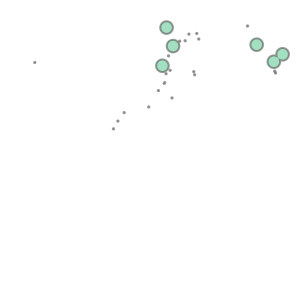

In [15]:
buffer_union

In [16]:
# create a series of true/false of those that do not intersect with the buffer should be tried to be directly imported into FoG (there WILL be mistakes) !!!
disjoint = lp.disjoint(buffer_union)

In [17]:
disjoint_ix = disjoint[disjoint == True].index
intersect_ix = disjoint[disjoint == False].index

In [18]:
disjoint_ix
intersect_ix

Int64Index([ 33,  42,  98,  99, 100, 101, 102, 103, 107, 177, 179, 181, 182,
            184, 185, 192, 193, 195, 203, 204, 205, 279, 280, 281, 282, 283,
            284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 296, 298, 311,
            312, 360, 364, 409, 769, 774, 777, 781, 792, 928, 971, 973, 974,
            975, 976, 978, 979, 980],
           dtype='int64')

In [19]:
# get the real geometries
fast_to_FoG = lp[lp.index.isin(disjoint_ix)]
check_closely = lp[lp.index.isin(intersect_ix)]

In [20]:
assert len(fast_to_FoG)+len(check_closely)==len(lp)

In [21]:
len(fast_to_FoG)

927

In [22]:
fast_to_FoG.head()

,AREA,ID,Mean_Slope,Type,abla_max,abla_mean,abla_min,accu_max,accu_mean,accu_min,data_void,dh_mean,distance,geometry,glacier_na,mean_elev
0,1.00926,0,11.463373,0,0.529638,0.019576,-0.539426,0.438751,0.044650,-0.225459,9.002639,0.031097,374904.390260,"POLYGON ((740432.9619000014 6926141.278299998,...",None,1937.799683
1,1.99968,1,10.652687,0,0.004134,-0.550919,-1.093450,0.214114,-0.675848,-1.267480,5.904943,-0.604927,364756.600625,"POLYGON ((747786.5420999993 6916886.153700002,...",None,1817.373535
2,1.43473,2,16.190556,0,0.075697,-0.669518,-1.507220,0.552516,-0.281408,-2.415110,7.550550,-0.495616,363653.089888,"POLYGON ((747510.9727267754 6915202.23442327, ...",None,1942.772827
3,2.06987,3,13.377052,0,0.176559,-0.357873,-1.367650,-0.281090,-0.894616,-2.092300,6.158355,-0.608700,357748.823628,"POLYGON ((732351.8668999996 6909953.610499999,...",None,1720.839233
4,2.65875,4,12.931275,0,0.171183,-0.681856,-1.759410,0.290771,-0.186491,-0.874991,4.075226,-0.459360,356117.889709,"POLYGON ((713898.410719209 6904324.999814478, ...",None,1804.301025


In [23]:
check_closely

,AREA,ID,Mean_Slope,Type,abla_max,abla_mean,abla_min,accu_max,accu_mean,accu_min,data_void,dh_mean,distance,geometry,glacier_na,mean_elev
33,3.00215,33,18.830402,0,0.344716,-0.312732,-1.312370,0.242153,-0.477323,-1.390730,18.405141,-0.395372,224074.356224,"POLYGON ((746074.9998341775 6773056.225430712,...",None,913.597717
42,1.01221,42,14.644270,0,0.206902,-0.445057,-0.996983,0.521611,-0.103062,-0.701605,14.168011,-0.310906,272644.705858,"POLYGON ((745148.592699999 6824103.747900001, ...",None,1430.897461
98,1.13004,98,23.650721,0,0.586458,-0.023359,-0.621055,0.822403,0.195514,-0.817854,6.410391,0.091609,205875.352640,"POLYGON ((737644.9997999993 6755937.163723909,...",None,920.911560
99,2.63139,99,16.919386,0,0.320668,-0.261414,-1.093490,0.965558,0.105564,-0.689937,9.097474,-0.024265,204150.152809,"POLYGON ((728464.9998000013 6753588.677457006,...",None,930.336975
100,3.44395,100,16.059942,0,0.271414,-0.619442,-1.183500,0.542939,-0.135497,-1.218060,6.433023,-0.329573,199603.228770,"POLYGON ((732814.9998320715 6751258.147479452,...",None,865.185669
101,2.19972,101,19.491079,0,0.038450,-0.825944,-1.593690,0.676488,-0.046044,-0.821681,10.315859,-0.329880,200570.198041,"POLYGON ((732604.9998000013 6751336.208099999,...",None,880.417053
102,1.13615,102,20.407553,0,0.016781,-0.002831,-0.018083,0.017147,0.002120,-0.030250,5.322360,-0.000083,196464.063616,"POLYGON ((722464.9998481076 6743934.477880321,...",None,667.706604
103,1.30590,103,21.630066,0,0.013560,-0.009115,-0.033968,0.021526,0.000961,-0.017814,6.797613,-0.003053,194692.533587,"POLYGON ((724114.9998481071 6742869.472909643,...",None,838.095947
107,1.13398,107,21.815912,0,-0.062151,-0.971373,-1.812690,0.447673,-0.162120,-0.696201,10.761213,-0.533045,192903.377765,"POLYGON ((725740.6302000002 6742391.136600001,...",None,641.532227
177,175.02199,177,12.496198,0,1.237790,-0.794808,-2.599360,3.499060,-0.603788,-4.412680,10.275850,-0.703190,275802.887168,"POLYGON ((774449.6368803063 6835234.999804827,...",Marcus Baker Glacier,1898.752808


In [24]:
template_a = pd.read_excel('C:\\users\\jlandman\\Desktop\\FoG_Subm_for_pandas.xls', sheetname='A - GENERAL INFORMATION')
template_b = pd.read_excel('C:\\users\\jlandman\\Desktop\\FoG_Subm_for_pandas.xls', sheetname='B - STATE')
template_d = pd.read_excel('C:\\users\\jlandman\\Desktop\\FoG_Subm_for_pandas.xls', sheetname='D - CHANGE')

In [25]:
assign_dict = {(3373, 'AIALIK'): np.nan,    # no equivalent 
               (3543, 'ALLEN'): np.nan,     # no equivalent
              (92, 'APPLEGATE'): 119,
              (102, 'BAKER'): 280,
              (105, 'BALTIMORE'): 214,
              (165, 'BARNARD'): 184,
              (168, 'BARRY'): 971,
              (1390, 'BARTLETT'): np.nan,  # no equ
              (3372, 'BEAR'): np.nan,      # no equ
              (3376, 'BEAR LAKE'): np.nan, # no eq 
              (97, 'BELOIT'): 302,
              (3377, 'BENCH'): np.nan,
              (98,'BLACKSTONE'): 980,
              (157,'BRILLIANT'): np.nan,
              (162,'BRYN MAWR'): 977,
              (169,'CASCADE'): 973,
              (100,'CATARACT'): 33,
              (180,'CHENEGA'): np.nan,
              (3379,'CHERNOF'): np.nan,
              (152,'CHILDS'): np.nan,
              (176,'CLAREMONT NORTH'): 311,
              (177,'CLAREMONT WEST'): 312,
              (3544,'COLONY'): 203,
              (156,'COLUMBIA (627)'): 976,
              (178,'CONTACT'): 325,   # is okay as only front variation present in FoG
              (167,'COXE'): 978,
              (3381,'DESERTED'): np.nan,
              (101,'DETACHED'): np.nan,
              (3382,'DINGLESTADT'): 364,
              (3383,'DOUBLE'): 774,   # ATTENTION: Name is different: DOUBLE in FoG, Big RIver Glacier in LP and Big River Lobe Double Glac in GLIMS
              (85,'EKLUTNA'): np.nan,
              (3790,'EXCELSIOR'): 981,
              (86,'EXIT'): np.nan,
              (91,'FALLING'): np.nan,
              (3386,'FORK TLIKAKILA'): 777,
              (3791,'GREWINGK'): np.nan,
              (172,'HARRIMAN'): 975,
              (160,'HARVARD'): np.nan,
              (3390,'HOLGATE'): 982,
              (166,'HOLYOKE'): 185,
              (3391,'KACHEMAK'): np.nan,
              (3310,'KNIK'): 204,
              (4333,'KNIK NORTH'): np.nan,  # part of KNIK (only one polygon in LP)
              (4332,'KNIK SOUTH'): np.nan,  # part of KNIK (only one polygon in LP)
              (95,'LAWRENCE'): 298,
              (173,'LEARNARD'): 100,
              (3394,'LITTLE DINGLESTADT'): 360,
              (3545,'MARCUS BAKER'): 177,
              (96,'MARQUETTE'): 301,
              (3546,'MATANUSKA E'): np.nan,  # one polygon together with MATANUSKA W in LP
              (3547,'MATANUSKA W'): np.nan,  # one polygon together with MATANUSKA E in LP
              (3396,'MC CARTY'): np.nan,
              (158,'MEARES'): np.nan,
              (3548,'NELCHINA'): np.nan,
              (179,'NELLIE JUAN'): np.nan,
              (3414,'NORTH FORK TLIKAKILA'): 769,
              (3399,'NORTHEASTERN'): 366,    # not absolutely sure if this is the one
              (3793,'NORTHWESTERN'): np.nan,
              (3794,'NUKA'): np.nan,         # VERY DIFFICULT CASE
              (103,'PENNIMAN EAST'): np.nan, # not really clear where the transition is
              (104,'PENNIMAN WEST'): 279,    # probably true but not 100% clear 
              (174,'PORTAGE'): 292,
              (3335,'RED'): np.nan,           
              (99,'ROARING'): np.nan,
              (108,'SADDLEBAG'): np.nan,
              (4334,'SCOTT'): np.nan,
              (170,'SERPENTINE'): 979,
              (3413,'SHAMROCK'): 781,
              (151,'SHERIDAN'): np.nan,
              (107,'SHERMAN'): np.nan,
              (155,'SHOUP'): 970,
              (3401,'SKILAK'): np.nan,
              (161,'SMITH'): np.nan,
              (3549,'SOUTH FORK TSINA'): 179,  # very strange naming, but this is it
              (1391,'SPENCER'): np.nan,        # FoG coordinate was wrong
              (171,'SURPRISE'): 974,
              (3403,'TANAINA'): 792,
              (93,'TAYLOR US'): 310,
              (3405,'TAZLINA'): np.nan,
              (175,'TEBENKOF'): np.nan,
              (3550,'TONSINA'): 195,
              (1389,'TRAIL'): 307,
              (3551,'TSINA'): 178,
              (3407,'TURQUOISE'): 787,
              (3408,'TUSTUMENA'): np.nan,
              (3409,'TUXEDNI'): 928, 
              (1387,'UNNAMED US0623'): np.nan,    # seems to be part of ID 976 in LP as B table says only 4km long
              (106,'UNNAMED US624'): np.nan,      # unclear which is meant; probably no equivalent
              (154,'VALDEZ'): 211,
              (163,'VASSAR'): 215,
              (164,'WELLESLEY'): 972,
              (94,'WOLVERINE'): np.nan,
              (3580,'WOODWORTH'): np.nan,
              (153,'WORTHINGTON'): 181,
              (3412,'WORTHMANNS'): np.nan,
              (159,'YALE'): np.nan,
              (3797,'YALIK'):409}

In [26]:
# constants
political_unit = 'US'
geogr_loc = 'Western Alaska Range'
year = 2006
survey_date = 20069999
ref_date = 19509999
surv_plat_meth = 'sP'
ref_plat_meth = 'aM'
remarks_b = 'Outlines derived by manual/automated digitizing based on large-scale 7.5 min topographic quadrangle maps. Some corrected manually.'
remarks_d = '1950s: Outlines and elevation derived from topograhic maps, 2006: elevation derived from SPOT5 HRS (SPIRIT)'
investigator = 'Raymond LE BRIS and Frank PAUL'
spons_agenc = 'Dept. of Geography, University of Zurich, Winterthurerstrasse 190, 8057 Zurich, Sitzerland'
ref = 'Le Bris, R. and Paul, F. (2015); Annals of Glaciology, 56(70), pp.184-192.'

In [ ]:
new_ids = range(10000, 11000, 1)

for ind, row in lp.iterrows():
    
    match_ix = rgi_ak.intersects(row.geometry)[rgi_ak.intersects(row.geometry) == True].index
    print(match_ix)
    rgi_match = rgi_ak[rgi_ak.index.isin(match_ix)]
    #print(rgi_match)
    if rgi_match.empty:
        rgi_match = pd.Series(data=None, index=rgi_ak.columns.values)
        #print(rgi_match.empty)
    
    if row.ID not in assign_dict.values():
        wgms_id = new_ids[0]
        new_ids = new_ids[1:]

        template_a.loc[ind, 'POLITCAL_UNIT'] = political_unit
        template_a.loc[ind, 'WGMS_ID'] = wgms_id
        template_a.loc[ind, 'GLACIER_NAME'] = row.glacier_na
        template_a.loc[ind, 'GEOGRAPHICAL_LOCATION_GENERAL']  = geogr_loc
        
        #print(rgi_match.empty)
        if pd.isnull(rgi_match.CenLat) or pd.isnull(rgi_match.CenLon):
            repres_point = row.geometry.representative_point()
            repres_point_ll = transform_coords(repres_point.x, repres_point.y,32605,4326) 
        else:
            repres_point_ll = (rgi_match.CenLon, rgi_match.CenLat)

        template_a.loc[ind, 'LATITUDE'] = round(repres_point_ll[1], 6)
        template_a.loc[ind, 'LONGITUDE'] = round(repres_point_ll[0], 6)
        template_a.loc[ind, 'REMARKS'] =  ''


        template_b.loc[ind, 'POLITICAL_UNIT'] = political_unit
        template_b.loc[ind, 'GLACIER_NAME'] = row.glacier_na
        template_b.loc[ind, 'WGMS_ID'] = wgms_id
        template_b.loc[ind, 'YEAR'] = str(rgi_match.BgnDate)[:5]
        template_b.loc[ind, 'MAXIMUM_ELEVATION_OF_GLACIER'] = rgi_match.Zmax
        template_b.loc[ind, 'MEDIAN_ELEVATION_OF_GLACIER'] = rgi_match.Zmed
        template_b.loc[ind, 'MINIMUM_ELEVATION_OF_GLACIER'] = rgi_match.Zmin
        template_b.loc[ind, 'LENGTH'] = rgi_match.Lmax
        template_b.loc[ind, 'AREA'] = rgi_match.Area
        template_b.loc[ind, 'SURVEY_DATE'] = rgi_match.BgnDate
        template_b.loc[ind, 'SURVEY_PLATFORM_METHOD'] = surv_plat_meth
        template_b.loc[ind, 'INVESTIGATOR'] = investigator
        template_b.loc[ind, 'SPONSORING_AGENCY'] = spons_agenc
        template_b.loc[ind, 'REFERENCE'] = ref
        template_b.loc[ind, 'REMARKS'] = remarks_b

        template_d.loc[ind, 'POLITICAL_UNIT'] = political_unit
        template_d.loc[ind, 'GLACIER_NAME'] = row.glacier_na
        template_d.loc[ind, 'WGMS_ID'] = wgms_id
        template_d.loc[ind, 'YEAR'] = year
        template_d.loc[ind, 'LOWER_BOUND'] = 9999.
        template_d.loc[ind, 'UPPER_BOUND'] = 9999.
        template_d.loc[ind, 'AREA_SURVEY_YEAR'] = year
        template_d.loc[ind, 'THICKNESS_CHANGE'] = row.dh_mean * 1000.  # unit: mm
        template_d.loc[ind, 'VOLUME_CHANGE'] = row.dh_mean * row.AREA * 1000.  # unit: m*km2*1000 = 1000m3
        template_d.loc[ind, 'REFERENCE_DATE'] = ref_date
        template_d.loc[ind, 'SURVEY_DATE'] = survey_date
        template_d.loc[ind, 'SURVEY_DATE_PLATFORM_METHOD'] = surv_plat_meth
        template_d.loc[ind, 'REFERENCE_DATE'] = ref_date
        template_d.loc[ind, 'REFERENCE_DATE_PLATFORM_METHOD'] = ref_plat_meth
        template_d.loc[ind, 'INVESTIGATOR'] = investigator
        template_d.loc[ind, 'SPONSORING_AGENCY'] = spons_agenc
        template_d.loc[ind, 'REFERENCE'] = ref
        template_d.loc[ind, 'REMARKS'] = remarks_d
    
    else:
        wgms_id = list(assign_dict.keys())[list(assign_dict.values()).index(row.ID)][0]
        gname = list(assign_dict.keys())[list(assign_dict.values()).index(row.ID)][1]
        
        template_b.loc[ind, 'POLITICAL_UNIT'] = political_unit
        template_b.loc[ind, 'GLACIER_NAME'] = gname
        template_b.loc[ind, 'WGMS_ID'] = wgms_id
        template_b.loc[ind, 'YEAR'] = year
        template_b.loc[ind, 'AREA'] = row.AREA
        template_b.loc[ind, 'SURVEY_DATE'] = survey_date
        template_b.loc[ind, 'SURVEY_PLATFORM_METHOD'] = surv_plat_meth
        template_b.loc[ind, 'INVESTIGATOR'] = investigator
        template_b.loc[ind, 'SPONSORING_AGENCY'] = spons_agenc
        template_b.loc[ind, 'REFERENCE'] = ref
        template_b.loc[ind, 'REMARKS'] = remarks_b

        template_d.loc[ind, 'POLITICAL_UNIT'] = political_unit
        template_d.loc[ind, 'GLACIER_NAME'] = row.glacier_na
        template_d.loc[ind, 'WGMS_ID'] = wgms_id
        template_d.loc[ind, 'YEAR'] = year
        template_d.loc[ind, 'LOWER_BOUND'] = 9999.
        template_d.loc[ind, 'UPPER_BOUND'] = 9999.
        template_d.loc[ind, 'AREA_SURVEY_YEAR'] = year
        template_d.loc[ind, 'THICKNESS_CHANGE'] = row.dh_mean * 1000.  # unit: mm
        template_d.loc[ind, 'VOLUME_CHANGE'] = row.dh_mean * row.AREA * 1000.  # unit: m*km2*1000 = 1000m3
        template_d.loc[ind, 'REFERENCE_DATE'] = ref_date
        template_d.loc[ind, 'SURVEY_DATE'] = survey_date
        template_d.loc[ind, 'SURVEY_DATE_PLATFORM_METHOD'] = surv_plat_meth
        template_d.loc[ind, 'REFERENCE_DATE'] = ref_date
        template_d.loc[ind, 'REFERENCE_DATE_PLATFORM_METHOD'] = ref_plat_meth
        template_d.loc[ind, 'INVESTIGATOR'] = investigator
        template_d.loc[ind, 'SPONSORING_AGENCY'] = spons_agenc
        template_d.loc[ind, 'REFERENCE'] = ref
        template_d.loc[ind, 'REMARKS'] = remarks_d
                   
template_d.head()

In [56]:
row

AREA                                                    86.9636
ID                                                          983
Mean_Slope                                              11.0661
Type                                                          2
abla_max                                                1.89836
abla_mean                                              -1.19806
abla_min                                                -5.2626
accu_max                                                1.96059
accu_mean                                             -0.461541
accu_min                                               -4.02532
data_void                                               1.20186
dh_mean                                               -0.864895
distance                                                 290690
geometry      POLYGON ((469409.9350182064 6524245.737075298,...
glacier_na                                                 None
mean_elev                               

In [57]:
template_a.to_excel('C:\\users\\jlandman\\Desktop\\RL_FP_to_FoG_automatic_A.xls', index=False)
template_b.to_excel('C:\\users\\jlandman\\Desktop\\RL_FP_to_FoG_automatic_B.xls', index=False)
template_d.to_excel('C:\\users\\jlandman\\Desktop\\RL_FP_to_FoG_automatic_D.xls', index=False)

In [58]:
len(template_a)

934

In [59]:
len(template_b)

984

In [60]:
len(template_d)

984

In [61]:
np.count_nonzero(~np.isnan(list(assign_dict.values())))

50

In [68]:
template_a.head()

,POLITCAL_UNIT,GLACIER_NAME,WGMS_ID,HYDROLOGICAL_CATCHEMENT_AREA,FREE_POSITION,LOCAL_CODE,LOCAL_PSFG,GEOGRAPHICAL_LOCATION_GENERAL,GEOGRAPHICAL _LOCATION_SPECIFIC,LATITUDE,LONGITUDE,PRIMARY_CLASSIFICATION,FORM,FRONTAL_CHARACTERISTICS,EXPOSITION_OF_ACCUMULATION_AREA,EXPOSITION_OF_ABLATION_AREA,PARENT_GLACIER,REMARKS
0,US,None,10000,NaN,NaN,NaN,NaN,Western Alaska Range,NaN,62.3834,-148.351,NaN,NaN,NaN,NaN,NaN,NaN,
1,US,None,10001,NaN,NaN,NaN,NaN,Western Alaska Range,NaN,62.2911,-148.205,NaN,NaN,NaN,NaN,NaN,NaN,
2,US,None,10002,NaN,NaN,NaN,NaN,Western Alaska Range,NaN,62.2787,-148.221,NaN,NaN,NaN,NaN,NaN,NaN,
3,US,None,10003,NaN,NaN,NaN,NaN,Western Alaska Range,NaN,62.2338,-148.524,NaN,NaN,NaN,NaN,NaN,NaN,
4,US,None,10004,NaN,NaN,NaN,NaN,Western Alaska Range,NaN,62.2146,-148.902,NaN,NaN,NaN,NaN,NaN,NaN,


# Assign GLIMS IDs

In [69]:
glims = salem.utils.read_shapefile('C:\\Users\\jlandman\\Desktop\\glims_db_20160429\\glims_polygons_alaska.shp')

In [139]:
glims_id_success = {}
glims_id_fail = {}

invest_date = dt.datetime.strptime(str(survey_date), '%Y%m%d') if str(survey_date)[4:]!='9999' else dt.datetime.strptime(str(survey_date)[:4]+'0630', '%Y%m%d')
ct=0
for k, row in template_a.iterrows():
    gp = shpg.Point(row.LONGITUDE, row.LATITUDE)
    rectangle = shpg.Polygon([(row.LONGITUDE-0.00001, row.LATITUDE-0.00001), (row.LONGITUDE+0.00001, row.LATITUDE-0.00001), (row.LONGITUDE+0.00001, row.LATITUDE+0.00001), (row.LONGITUDE-0.00001, row.LATITUDE+0.00001)])
    subset = glims[glims.intersects(rectangle)]
    if len(subset) == 1:
        if subset.geometry.iloc[0].contains(gp):
            glims_id_success[row.WGMS_ID] = subset['glac_id']
        else:
            glims_id_fail[row.WGMS_ID] = np.nan
    elif len(subset) > 1:
        glims_inv = [dt.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in subset.src_date.values]    # GLIMS investigation date
        date_diffs = [abs(invest_date-i) for i in glims_inv]  # absolute date differences to get the closest investigation date
        ix_date_close = date_diffs.index(min(date_diffs))  # find index of the closest date
        glims_id_close = subset.iloc[ix_date_close].glac_id # get closest GLIMS ID
        glims_id_success[row.WGMS_ID] = glims_id_close
        print(subset.src_date.values, subset.glac_id.values,glims_id_close)
    else:
        glims_id_fail[row.WGMS_ID] = np.nan

['2007-07-16T00:00:00' '2009-08-03T00:00:00'] ['G211421E61184N' 'G211426E61177N'] G211421E61184N
['2007-07-16T00:00:00' '2009-08-03T00:00:00'] ['G211620E60922N' 'G211617E60918N'] G211620E60922N
['2007-07-16T00:00:00' '2009-09-06T00:00:00'] ['G212660E61138N' 'G212661E61140N'] G212660E61138N
['2007-07-16T00:00:00' '2009-08-03T00:00:00'] ['G212089E61471N' 'G211846E61437N'] G212089E61471N
['2006-09-12T00:00:00' '2006-09-12T00:00:00'] ['G210808E60346N' 'G210808E60346N'] G210808E60346N
['2006-09-12T00:00:00' '2006-09-12T00:00:00' '2006-09-12T00:00:00'] ['G210019E60181N' 'G210005E60132N' 'G210005E60132N'] G210019E60181N
['2007-07-16T00:00:00' '2009-08-03T00:00:00'] ['G212078E61572N' 'G212090E61565N'] G212078E61572N
['2007-07-16T00:00:00' '2009-09-06T00:00:00'] ['G213981E61263N' 'G213982E61241N'] G213981E61263N
['2007-07-16T00:00:00' '2009-08-03T00:00:00'] ['G211709E61273N' 'G211708E61247N'] G211709E61273N
['2007-07-16T00:00:00' '2009-09-06T00:00:00'] ['G213343E61204N' 'G213345E61206N'] G21334

In [130]:
invest_date = dt.datetime.strptime(str(survey_date), '%Y%m%d') if str(survey_date)[4:]!='9999' else dt.datetime.strptime(str(survey_date)[:4]+'0630', '%Y%m%d')
glims_inv = [dt.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in subset.anlys_time.values]
min([abs(invest_date- i) for i in glims_inv])


datetime.timedelta(1295)

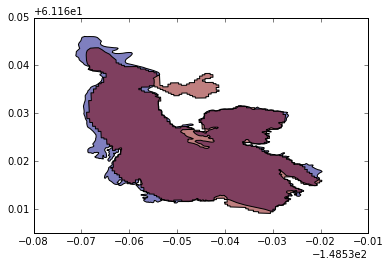

In [118]:
subset.plot()

In [99]:
len(glims_id_success)

765

In [100]:
len(glims_id_fail)

1

In [101]:
len(template_a)

934

In [102]:
glims_id_success

{10004: 'G211096E62213N',
 10006: 'G211518E62144N',
 10007: 'G210776E62125N',
 10008: 'G211068E62097N',
 10009: 'G211254E62105N',
 10012: 'G211143E62040N',
 10014: 'G210961E62041N',
 10015: 'G210913E62055N',
 10020: 'G211176E61919N',
 10023: 'G211201E61911N',
 10025: 'G211115E61908N',
 10027: 'G210934E61885N',
 10029: 'G210940E61870N',
 10030: 'G210896E61859N',
 10031: 'G210878E61859N',
 10032: 'G211426E61177N',
 10033: 'G211617E60918N',
 10034: 'G214151E61165N',
 10035: 'G212661E61140N',
 10037: 'G212543E61621N',
 10038: 'G212567E61605N',
 10039: 'G212868E61563N',
 10040: 'G211693E61508N',
 10041: 'G211614E61460N',
 10043: 'G211846E61437N',
 10049: 'G215048E61349N',
 10051: 'G211761E61332N',
 10054: 'G214922E61321N',
 10055: 'G214944E61295N',
 10056: 'G211330E61295N',
 10058: 'G211598E61261N',
 10059: 'G214388E61269N',
 10060: 'G214304E61246N',
 10062: 'G211593E61237N',
 10063: 'G214191E61237N',
 10065: 'G214914E61086N',
 10066: 'G211446E61207N',
 10067: 'G211433E61198N',
 10068: 'G21